# Testing Mouth Open/Close Detection

In [1]:
from commonfunctions import *
import math
from skimage import filters
from skimage import data
from skimage.color import rgb2gray

import dlib

%matplotlib inline
%load_ext autoreload
%autoreload 2

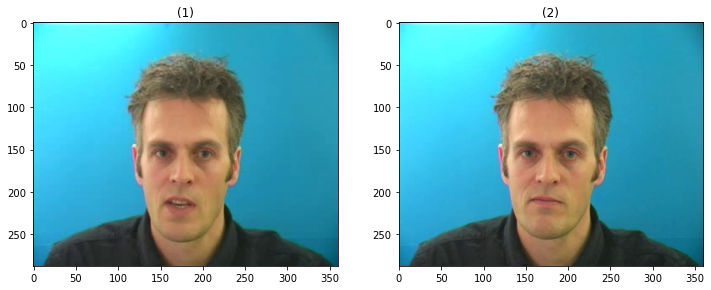

In [2]:
img_open = io.imread('frame0.jpg')
img_close = io.imread('frame69.jpg')
show_images([img_open, img_close])

In [3]:
def detectMouth(img):
    # detect face:
    detector = dlib.get_frontal_face_detector()
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))

    face = img[d.top():d.bottom(), d.left():d.right()]
    dimensions_face=face.shape
    mouth = face[int(dimensions_face[0]/2)+10:,:,:]

    quarter_face=mouth.shape[1]//4
    mouth= mouth[:,quarter_face:quarter_face*3,:]

    dimensions_mouth=mouth.shape

    io.imshow(mouth)
    io.show()
    return mouth , dimensions_mouth

In [4]:
def selectLipRegion(mouth, dimensions_mouth):
    R = mouth[:,:,0]
    G = mouth[:,:,1]

    print(mouth.shape)
    # calculate chromatism
    chromatism = 2 * np.arctan((R-G)/R) / np.pi

    io.imshow(chromatism)
    io.show()
    chromatism = chromatism.reshape(-1,1)

    sorted_chromatism = -np.sort(-chromatism,axis=None,)

    chromatism_mouth_perc = int(chromatism.shape[0] * 0.15)
    print(chromatism_mouth_perc)
    chromatsim_largest_twenty=sorted_chromatism[0:chromatism_mouth_perc]


    chromatism = chromatism.reshape(dimensions_mouth[0],dimensions_mouth[1])
    io.imshow(chromatism)
    io.show()

    #print(chromatism in chromatsim_largest_twenty)
    new_img = np.zeros(dimensions_mouth)

    for i in range(0,dimensions_mouth[0]):
        for j in range(0,dimensions_mouth[1]):
            if chromatism[i,j] in chromatsim_largest_twenty:
                new_img[i,j]=255
            else:
                new_img[i,j]=0

    #new_img = chromatism[x for x in chromatsim_largest_twenty]
    io.imshow(new_img)
    io.show()



Number of faces detected: 1
Detection 0: Left: 110 Top: 125 Right: 239 Bottom: 254


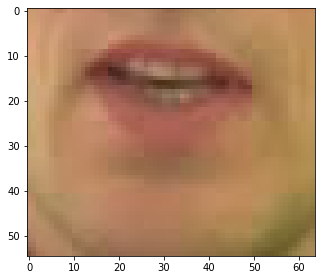

(55, 64, 3)


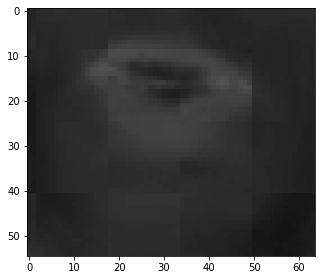

528


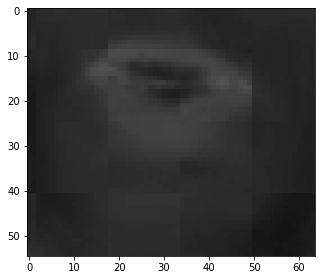

C:\Users\HP\anaconda3\envs\cufe\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


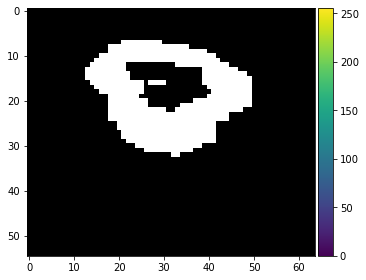

Number of faces detected: 1
Detection 0: Left: 110 Top: 125 Right: 239 Bottom: 254


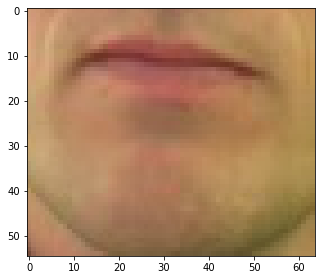

(55, 64, 3)


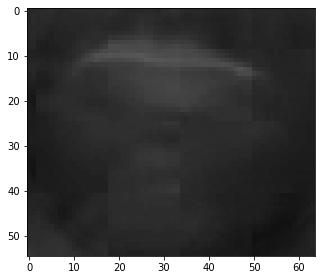

528


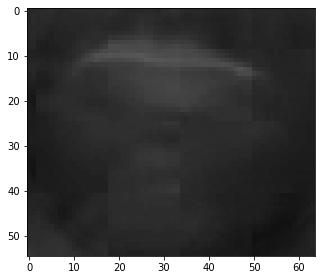

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


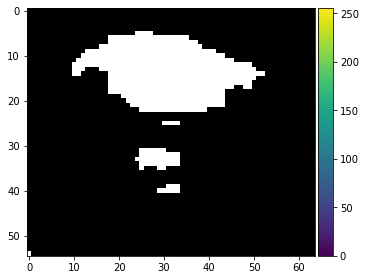

In [5]:
mouth_open , dim_open = detectMouth(img_open)
selectLipRegion(mouth_open, dim_open)
########################################################################################################################
mouth_close , dim_close = detectMouth(img_close)
selectLipRegion(mouth_close, dim_close)


### Challenges:
1. how to detect whether lips is connected or not -> when to select one biggest contour / 2 biggest contours?

# Find mouth contours


In [ ]:
#calculate threshold T for segmentation

